In [206]:
import os
import math
import csv
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

In [104]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

spark = SparkSession.builder.master('local').getOrCreate()

In [4]:
df = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/sample-data/DataSample.csv'))
df.printSchema()

root
 |-- _ID: integer (nullable = true)
 |-- TimeSt: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [5]:
df.createOrReplaceTempView('filter_frame')

In [6]:
df_filtered = spark.sql("""select distinct TimeSt, Country, Province, City, Latitude, Longitude from filter_frame""")

In [7]:
df_filtered.createOrReplaceTempView('filtered_frame')
df_filtered.show()

+--------------------+-------+--------+----------------+--------+----------+
|              TimeSt|Country|Province|            City|Latitude| Longitude|
+--------------------+-------+--------+----------------+--------+----------+
|2017-06-21 02:00:...|     CA|      AB|         Calgary| 51.0823| -113.9578|
|2017-06-21 01:00:...|     CA|      ON|         Toronto| 43.6466|  -79.4493|
|2017-06-21 12:01:...|     CA|      ON|          Guelph| 43.5412|  -80.2469|
|2017-06-21 04:01:...|     CA|      ON|         Lindsay|  44.357|  -78.7405|
|2017-06-21 18:01:...|     CA|      ON|       North Bay| 46.3377|  -79.3717|
|2017-06-21 18:04:...|     CA|      QC|           Laval| 45.6236|  -73.6861|
|2017-06-21 06:04:...|     CA|      AB|   Sherwood Park|53.52284|-113.33213|
|2017-06-21 14:05:...|     CA|      QC|Vaudreuil-Dorion| 45.3838|   -74.041|
|2017-06-21 01:06:...|     CA|      NS|          Sydney| 46.1612|  -60.1823|
|2017-06-21 20:07:...|     CA|      NB|         Moncton| 46.1033|   -64.815|

In [8]:
poiDf = spark.read.options(
    header="True", 
    inferSchema="True",
    delimiter=",",
).csv(os.path.expanduser('~/sample-data/POIList.csv'))
poiDf.printSchema()

root
 |-- POIID: string (nullable = true)
 |--  Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [9]:
poiDf.createOrReplaceTempView('poi')
poiDf.show()

+-----+---------+-----------+
|POIID| Latitude|  Longitude|
+-----+---------+-----------+
| POI1|53.546167|-113.485734|
| POI2|53.546167|-113.485734|
| POI3|45.521629| -73.566024|
| POI4| 45.22483| -63.232729|
+-----+---------+-----------+



In [10]:
def distance(P_Latitude, P_Longitude, Latitude, Longitude):
    '''To find the minimum distance of each request longitude
        and latitude from a POI and assign a POI to a request.
        
        P_Latitude: Latitude column of the POI
        P_Longitude: Longitude column of the POI
        Latitude: Latitude column of the request
        Longitude: Longitude column of the request'''

    return ((P_Latitude-Latitude)**2 + (P_Longitude-Longitude)**2)**(1/2)

# Registering user defined function into spark
spark.udf.register(name="distance", f=distance)

<function __main__.distance(P_Latitude, P_Longitude, Latitude, Longitude)>

In [91]:
# Extracting data from POI for POI assignment
POIs = dict()
with open('../sample-data/POIList.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for line in reader:
        if i>0:
            POI_ID = line[0]
            latitude = float(line[1])
            longitude = float(line[2])
            POIs[POI_ID] = (latitude, longitude)
        i += 1    
print(POIs)

{'POI1': (53.546167, -113.485734), 'POI2': (53.546167, -113.485734), 'POI3': (45.521629, -73.566024), 'POI4': (45.22483, -63.232729)}


In [109]:
# Defining a function for finding nearest POI
def calcNearestPOI(latitude, longitude):
    '''For finding the nearest POI from the given data.
        latitude: Latitude of the request
        longitude: Longitude of the request
        POIDict: dictionary containing POI data
        
        Returns: nearest POI string and distance from POI.
                 If two POI are equally situated, first one is returned.'''
    l = dict()
    for k, v in POIs.items():
        P_lat = v[0]
        P_long = v[1]
        lat_diff = latitude-P_lat
        long_diff = longitude-P_long
        distance = round(math.sqrt((lat_diff)**2 + (long_diff)**2), 4)
        l[k] = distance
    
    mini = min(l, key=l.get)
    return (mini, l[mini])

def nearestPOI(latitude, longitude):
    poi = calcNearestPOI(latitude, longitude)[0]
    return poi

def distancePOI(latitude, longitude):
    dis = calcNearestPOI(latitude, longitude)[1]
    return dis
# Test
print(distancePOI(63.0823, -130.9578))        
# Registering the above function in spark sql
spark.udf.register(name='nearestPOI', f=nearestPOI)
spark.udf.register('distancePOI', distancePOI, FloatType())

19.905


<function __main__.distancePOI(latitude, longitude)>

In [110]:
newTable = spark.sql('select TimeSt, Country, Province, City, filtered_frame.Latitude, filtered_frame.Longitude, distancePOI(filtered_frame.Latitude, filtered_frame.Longitude) as Distance_from_POI, nearestPOI(filtered_frame.Latitude, filtered_frame.Longitude) as Nearest_POI from filtered_frame')       

In [114]:
newTable.createOrReplaceTempView('newTableView')
#ww = spark.sql('select * from newTableView')
newTable.show()
#ww.show()

+--------------------+-------+--------+----------------+--------+----------+-----------------+-----------+
|              TimeSt|Country|Province|            City|Latitude| Longitude|Distance_from_POI|Nearest_POI|
+--------------------+-------+--------+----------------+--------+----------+-----------------+-----------+
|2017-06-21 02:00:...|     CA|      AB|         Calgary| 51.0823| -113.9578|           2.5087|       POI1|
|2017-06-21 01:00:...|     CA|      ON|         Toronto| 43.6466|  -79.4493|           6.1748|       POI3|
|2017-06-21 12:01:...|     CA|      ON|          Guelph| 43.5412|  -80.2469|           6.9682|       POI3|
|2017-06-21 04:01:...|     CA|      ON|         Lindsay|  44.357|  -78.7405|           5.3039|       POI3|
|2017-06-21 18:01:...|     CA|      ON|       North Bay| 46.3377|  -79.3717|           5.8628|       POI3|
|2017-06-21 18:04:...|     CA|      QC|           Laval| 45.6236|  -73.6861|           0.1575|       POI3|
|2017-06-21 06:04:...|     CA|      A

In [115]:
POI1 = spark.sql('select * from newTableView where Nearest_POI = "POI1"')
POI2 = spark.sql('select * from newTableView where Nearest_POI = "POI2"')
POI3 = spark.sql('select * from newTableView where Nearest_POI = "POI3"')
POI4 = spark.sql('select * from newTableView where Nearest_POI = "POI4"')

POI1.createOrReplaceTempView('poi1view')
POI2.createOrReplaceTempView('poi2view')
POI3.createOrReplaceTempView('poi3view')
POI4.createOrReplaceTempView('poi4view')

In [116]:
# For Example
POI1.show()

+--------------------+-------+--------+-------------+--------+----------+-----------------+-----------+
|              TimeSt|Country|Province|         City|Latitude| Longitude|Distance_from_POI|Nearest_POI|
+--------------------+-------+--------+-------------+--------+----------+-----------------+-----------+
|2017-06-21 02:00:...|     CA|      AB|      Calgary| 51.0823| -113.9578|           2.5087|       POI1|
|2017-06-21 06:04:...|     CA|      AB|Sherwood Park|53.52284|-113.33213|           0.1554|       POI1|
|2017-06-21 19:08:...|     CA|      AB|     Beaumont| 53.3501| -113.4187|           0.2072|       POI1|
|2017-06-21 09:09:...|     CA|      AB|      Calgary|50.87401|-113.98432|           2.7183|       POI1|
|2017-06-21 18:10:...|     CA|      AB|      Calgary|51.03297|-113.98352|            2.562|       POI1|
|2017-06-21 18:10:...|     CA|      AB|      Calgary| 51.1563| -114.0572|           2.4572|       POI1|
|2017-06-21 21:12:...|     CA|      BC|     Richmond|49.16542|-1

In [117]:
# Calculating the Average distance and standard deviation of the distances from all the 4 POIs
stats1 = spark.sql('select round(avg(distance_from_POI), 4) as Mean_distance_from_POI1, round(std(distance_from_POI), 4) as Standard_deviation_distances from poi1view')
stats2 = spark.sql('select round(avg(distance_from_POI), 4) as Mean_distance_from_POI2, round(std(distance_from_POI), 4) as Standard_deviation_distances from poi2view')
stats3 = spark.sql('select round(avg(distance_from_POI), 4) as Mean_distance_from_POI3, round(std(distance_from_POI), 4) as Standard_deviation_distances from poi3view')
stats4 = spark.sql('select round(avg(distance_from_POI), 4) as Mean_distance_from_POI4, round(std(distance_from_POI), 4) as Standard_deviation_distances from poi4view')

In [118]:
stats1.show()
stats2.show() # This shows null because POI1 and POI2 have same coordinates and none of the requests get assigned POI2
stats3.show()
stats4.show()

+-----------------------+----------------------------+
|Mean_distance_from_POI1|Standard_deviation_distances|
+-----------------------+----------------------------+
|                 3.3482|                      3.8585|
+-----------------------+----------------------------+

+-----------------------+----------------------------+
|Mean_distance_from_POI2|Standard_deviation_distances|
+-----------------------+----------------------------+
|                   null|                        null|
+-----------------------+----------------------------+

+-----------------------+----------------------------+
|Mean_distance_from_POI3|Standard_deviation_distances|
+-----------------------+----------------------------+
|                 5.5379|                      2.8587|
+-----------------------+----------------------------+

+-----------------------+----------------------------+
|Mean_distance_from_POI4|Standard_deviation_distances|
+-----------------------+----------------------------+
|      

# Plotting Section
This code section is used for plotting data for assigned requests and POI. Each POI is plotted in seperate plots.

In [174]:
x1 = POI1.select("Latitude").rdd.flatMap(lambda x: x).collect()
y1 = POI1.select("Longitude").rdd.flatMap(lambda x: x).collect()

x3 = POI3.select("Latitude").rdd.flatMap(lambda x: x).collect()
y3 = POI3.select("Longitude").rdd.flatMap(lambda x: x).collect()

x4 = POI4.select("Latitude").rdd.flatMap(lambda x: x).collect()
y4 = POI4.select("Longitude").rdd.flatMap(lambda x: x).collect()

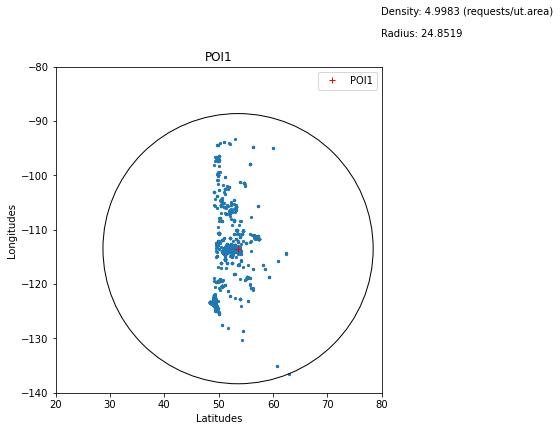

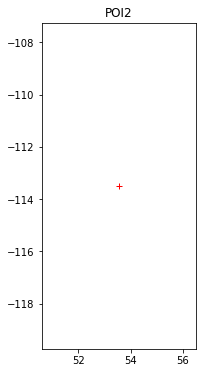

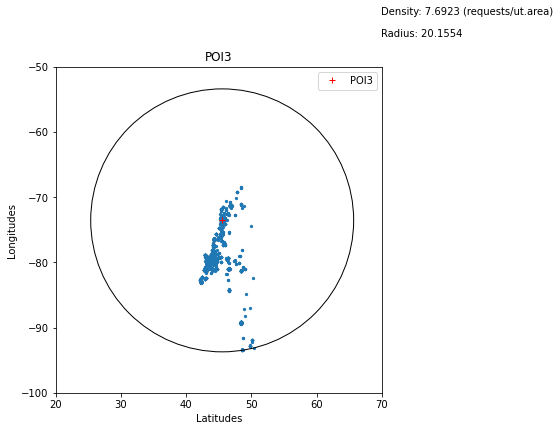

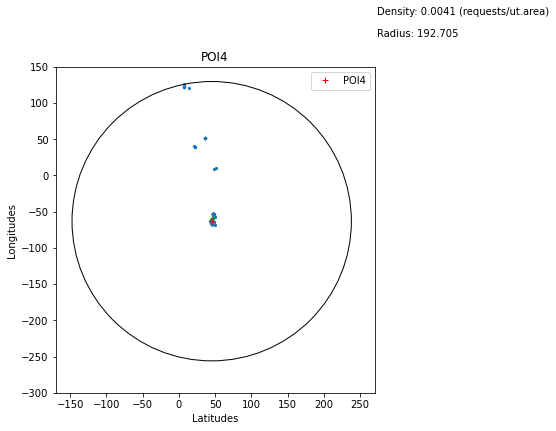

In [216]:
co_or1 = spark.sql('select round(count(*)/(3.1415*pow(max(distance_from_POI),2)), 4) as Density_POI1, max(distance_from_POI) as Radius_POI1 from poi1view')
co_or1.createOrReplaceTempView('coordinates1')

co_or2 = spark.sql('select round(count(*)/(3.1415*pow(max(distance_from_POI),2)), 4) as Density_POI2, max(distance_from_POI) as Radius_POI2 from newTableView where Nearest_POI="POI2"')
co_or2.createOrReplaceTempView('coordinates2')

co_or3 = spark.sql('select round(count(*)/(3.1415*pow(max(distance_from_POI),2)), 4) as Density_POI3, max(distance_from_POI) as Radius_POI3 from newTableView where Nearest_POI="POI3"')
co_or3.createOrReplaceTempView('coordinates3')

co_or4 = spark.sql('select round(count(*)/(3.1415*pow(max(distance_from_POI),2)), 4) as Density_POI4, max(distance_from_POI) as Radius_POI4 from newTableView where Nearest_POI="POI4"')
co_or4.createOrReplaceTempView('coordinates4')
try:
    # POI 1
    density_1 = float(co_or1.select("Density_POI1").rdd.flatMap(lambda x: x).collect()[0])
    radius_1 = float(co_or1.select("Radius_POI1").rdd.flatMap(lambda x: x).collect()[0])
    figure, axes = plt.subplots()
    poi1_x = POIs['POI1'][0]
    poi1_y = POIs['POI1'][1]
    plt.xlim(20,80)
    plt.ylim(-140,-80)
    plt.xlabel('Latitudes')
    plt.ylabel('Longitudes')
    axes.set_aspect(1)
    
    # Plotting requests
    plt.scatter(x1, y1, 5)
    
    # Plotting POI 1 and circle
    poi, = plt.plot(poi1_x, poi1_y, 'r+')
    circle = plt.Circle((poi1_x,poi1_y), radius_1, fill=False)
    axes.add_artist(circle)
    plt.title('POI1')
    plt.legend([poi], ['POI1'])
    plt.figtext(0.7,1, 'Density: {} (requests/ut.area)'.format(density_1))
    plt.figtext(0.7,0.95, 'Radius: {}'.format(round(radius_1, 4)))
    plt.show()
    
    # POI 2
    poi2_x = POIs['POI2'][0]
    poi2_y = POIs['POI2'][1]
    figure, axes = plt.subplots()
    axes.set_aspect(1)
    plt.plot(poi2_x, poi2_y, 'r+')
    plt.title('POI2')
    plt.show()
    
    # POI 3
    density_3 = float(co_or3.select("Density_POI3").rdd.flatMap(lambda x: x).collect()[0])
    radius_3 = float(co_or3.select("Radius_POI3").rdd.flatMap(lambda x: x).collect()[0])
    figure, axes = plt.subplots()
    poi3_x = POIs['POI3'][0]
    poi3_y = POIs['POI3'][1]
    plt.xlim(20,70)
    plt.ylim(-100,-50)
    plt.xlabel('Latitudes')
    plt.ylabel('Longitudes')
    axes.set_aspect(1)
    
    # Plotting requests
    plt.scatter(x3, y3, 5)
    
    # Plotting POI 1 and circle
    poi, = plt.plot(poi3_x, poi3_y, 'r+')
    circle = plt.Circle((poi3_x,poi3_y), radius_3, fill=False)
    axes.add_artist(circle)
    plt.title('POI3')
    plt.legend([poi], ['POI3'])
    plt.figtext(0.7,1, 'Density: {} (requests/ut.area)'.format(density_3))
    plt.figtext(0.7,0.95, 'Radius: {}'.format(round(radius_3, 4)))
    plt.show()
    
    # POI 4
    density_4 = float(co_or4.select("Density_POI4").rdd.flatMap(lambda x: x).collect()[0])
    radius_4 = float(co_or4.select("Radius_POI4").rdd.flatMap(lambda x: x).collect()[0])
    figure, axes = plt.subplots()
    poi4_x = POIs['POI4'][0]
    poi4_y = POIs['POI4'][1]
    plt.xlim(-170,270)
    plt.ylim(-300,150)
    plt.xlabel('Latitudes')
    plt.ylabel('Longitudes')
    axes.set_aspect(1)
    
    # Plotting requests
    plt.scatter(x4, y4, 5)
    
    # Plotting POI 1 and circle
    poi, = plt.plot(poi4_x, poi4_y, 'r+')
    circle = plt.Circle((poi4_x,poi4_y), radius_4, fill=False)
    axes.add_artist(circle)
    plt.title('POI4')
    plt.legend([poi], ['POI4'])
    plt.figtext(0.7,1, 'Density: {} (requests/ut.area)'.format(density_4))
    plt.figtext(0.7,0.95, 'Radius: {}'.format(round(radius_4, 4)))
    plt.show()
    
except Exception as e:
    print(e)

# Model
In order for data to be in scale from -10 to 10, we have to transform coordinates. This can be done by dividing the longitudes by 15 and transforming latitudes using the formula below. This number is chosen so that the data points around the average are as visually differentiabe as possible and is based on max and min values of coordinates.

    So, Latitude = (Latitude / 5) - 5
        Longitude = Longitude / 15
        
For adding for visual differntiability, different colors are used for different request assignments. 

##### Note:
Visualization could also be done using geo plotting in plotly package. Since it is not available in the current working image and to allow using the scale, I proceeded with matplotlib.

In [320]:
# Transformations
x1_t = [(i/5-5) for i in x1]
y1_t = [i/15 for i in y1]

x3_t = [(i/5-5) for i in x3]
y3_t = [i/15 for i in y3]

x4_t = [(i/5-5) for i in x4]
y4_t = [i/15 for i in y4]

# Transforming POIs
POIs_t = dict()

for k, v in POIs.items():
    POIs_t[k] = (round(v[0]/5 -5, 4), round(v[1]/15, 4))

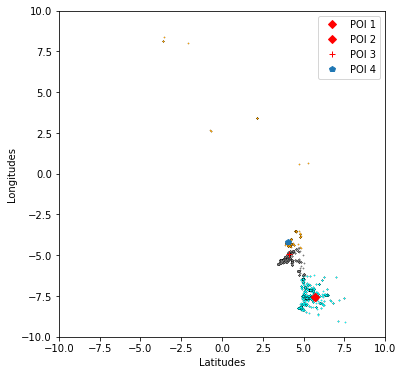

In [322]:
figure, axes = plt.subplots()
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('Latitudes')
plt.ylabel('Longitudes')
axes.set_aspect(1)
p1 = plt.scatter(x1_t, y1_t, s=2,c='cyan', edgecolor='black', linewidth=0.1)
p3 = plt.scatter(x3_t, y3_t, s=2,c='grey', edgecolor='black', linewidth=0.1)
p4 = plt.scatter(x4_t, y4_t, s=2,c='orange', edgecolor='black', linewidth=0.1)

leg = []
i = 0
for v in POIs_t.values():
    x = v[0]
    y = v[1]
    if i == 0 or i == 1:
        mark = 'rD'
    elif i == 2:
        mark = 'r+'
    else:
        mark = 'p'
    leg.extend(plt.plot(x, y, mark))
    i += 1    
    
plt.legend(leg, ['POI 1', 'POI 2', 'POI 3', 'POI 4'])    

### Bonus
Data analysis based on the visualization is included in bonus.txt fille